In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

from lib import dpf, panda_models, panda_datasets
from lib.utils import file_utils, torch_utils, misc_utils

print(torch.__version__, np.__version__)

1.3.0 1.17.3


In [16]:
# Load dataset
trainset = panda_datasets.PandaParticleFilterDataset(
    "data/pull-test-tiny.hdf5",
    #"data/push-test-small.hdf5",
    use_proprioception=True,
    use_vision=True,
    vision_interval=10
)
trainset_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

Parsed data: 534 active, 224 inactive
Keeping: 224


In [4]:
# Create model & training buddy
#experiment_name = "push_pull_no_prev"
experiment_name = "test2"

dynamics_model = panda_models.PandaDynamicsModel(units=16)
measurement_model = panda_models.PandaMeasurementModel(units=16)

pf_model = dpf.ParticleFilterNetwork(dynamics_model, measurement_model)

buddy = torch_utils.TrainingBuddy(experiment_name, pf_model, log_dir="logs/pf", checkpoint_dir="checkpoints/pf")

Using device: cpu
No checkpoint found


In [8]:
def train(log_interval=10):
    # Train for 1 epoch
    for batch_idx, batch in enumerate(trainset_loader):
        # Transfer to GPU and pull out batch data
        batch_gpu = torch_utils.to_device(batch, buddy._device)
        batch_particles, batch_states, batch_obs, batch_controls = batch_gpu

        # N = batch size, M = particle count
        N, timesteps, control_dim = batch_controls.shape
        N, timesteps, state_dim = batch_states.shape
        N, M, state_dim = batch_particles.shape
        assert batch_controls.shape == (N, timesteps, control_dim)

        # Give all particle equal weights
        particles = batch_particles
        log_weights = torch.ones((N, M), device=buddy._device) * (-np.log(M))

        for t in range(1, timesteps):
            prev_particles = particles
            prev_log_weights = log_weights

            state_estimates, new_particles, new_log_weights = pf_model.forward(
                prev_particles,
                prev_log_weights,
                misc_utils.DictIterator(batch_obs)[:,t - 1,:],
                batch_controls[:,t,:],
                resample=False
            )

            loss = dpf.gmm_loss(
                particles_states=new_particles,
                log_weights=new_log_weights,
                true_states=batch_states[:, t, :],
                gmm_variances=np.array([0.2, 0.05])
            )

            buddy.minimize(loss)
            # Disable backprop through time
            particles = new_particles.detach()
            log_weights = new_log_weights.detach()

            if buddy._steps % log_interval == 0:
                buddy.log("Training loss:", loss)



In [11]:
pf_model.freeze_measurement_model = False
pf_model.freeze_dynamics_model = True
for i in range(100):
    print("Training epoch", i)
    train(log_interval=1)

Training epoch 0
Training epoch 1
Saved checkpoint to path: checkpoints_pf/test2-4000.ckpt
Training epoch 2
Training epoch 3
Training epoch 4
Training epoch 5
Saved checkpoint to path: checkpoints_pf/test2-5000.ckpt
Training epoch 6
Training epoch 7
Training epoch 8
Training epoch 9
Training epoch 10
Saved checkpoint to path: checkpoints_pf/test2-6000.ckpt
Training epoch 11
Training epoch 12
Training epoch 13
Training epoch 14
Saved checkpoint to path: checkpoints_pf/test2-7000.ckpt
Training epoch 15


KeyboardInterrupt: 

In [ ]:
buddy.save_checkpoint()

In [25]:
def eval(pf_model, trajectories):
    # To make things easier, we're going to cut all our trajectories to the same length :)
    timesteps = np.min([len(s) for s, _, _ in trajectories])
    predicted_states = [[states[0]] for states, _, _ in trajectories]
    actual_states = [states[:timesteps] for states, _, _ in trajectories]

    state_dim = len(actual_states[0][0])
    N = len(trajectories)
    M = 200

    particles = torch.zeros((N, M, state_dim), device=buddy._device)
    log_weights = torch.ones((N, M), device=buddy._device) * (-np.log(M))

    for t in range(1, timesteps):
        s = []
        o = {}
        c = []
        for i, traj in enumerate(trajectories):
            states, observations, controls = traj

            s.append(predicted_states[i][t - 1])
            o_t = misc_utils.DictIterator(observations)[t]
            misc_utils.DictIterator(o).append(o_t)
            c.append(controls[t])

        print(s)
        s = np.array(s)
        misc_utils.DictIterator(o).convert_to_numpy()
        c = np.array(c)
        (s, o, c) = torch_utils.to_torch((s, o, c), device=buddy._device)

        state_estimates, new_particles, new_log_weights = pf_model.forward(
            particles,
            log_weights,
            o,
            c,
            resample=True
        )
        
        for i in range(len(trajectories)):
            predicted_states[i].append(torch_utils.to_numpy(state_estimates[i]))

        misc_utils.progress_bar(t / timesteps)
    misc_utils.progress_bar(1.)

    predicted_states = np.array(predicted_states)
    actual_states = np.array(actual_states)
    return predicted_states, actual_states


eval_trajectories = file_utils.load_trajectories("data/pull-test-tiny.hdf5", use_proprioception=False)
pred, actual = eval(pf_model, eval_trajectories[5:6])

Progress: [####################] 100.0%


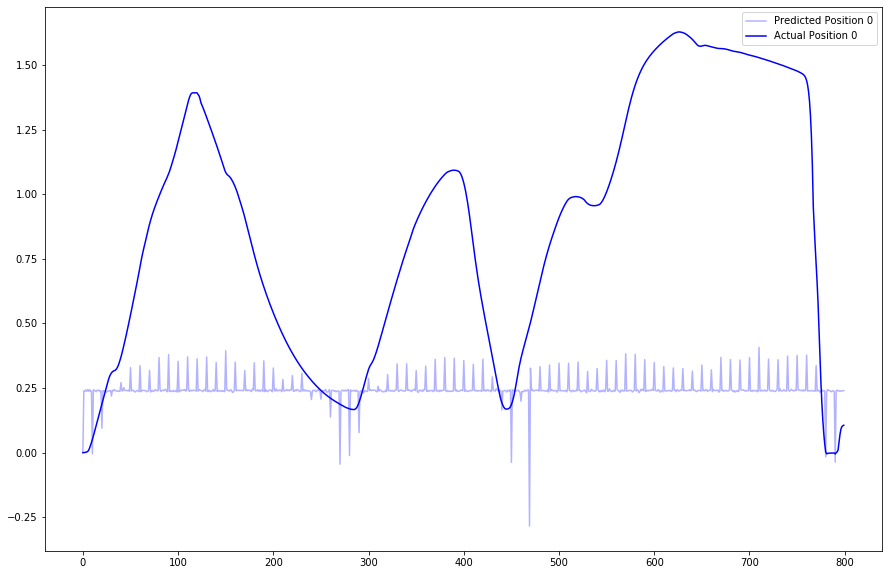

(1, 800, 2)
Position MSE:  0.6478427


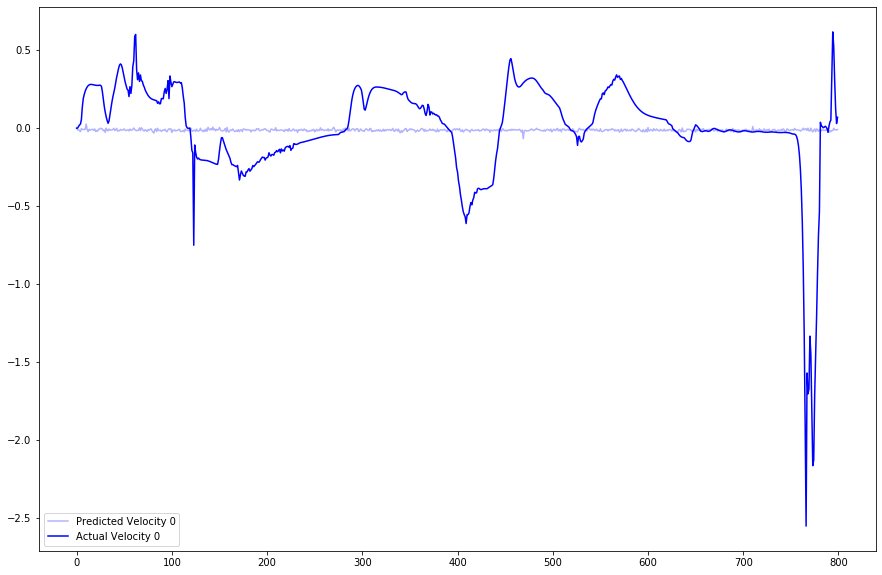

Velocity MSE:  0.09959484


In [26]:
def vis_eval(predicted_states, actual_states):
    timesteps = len(actual_states[0])

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    
    plt.figure(figsize=(15,10))    
    for i, (pred, actual) in enumerate(zip(predicted_states, actual_states)):
        plt.plot(range(timesteps), pred[:,0], label="Predicted Position " + str(i), c=colors[i], alpha=0.3)
        plt.plot(range(timesteps), actual[:,0], label="Actual Position " + str(i), c=colors[i])
    plt.legend()
    plt.show()
    print(predicted_states.shape)
    print("Position MSE: ", np.mean((predicted_states[:,:,0] - actual_states[:,:,0])**2))

    plt.figure(figsize=(15,10))    
    for i, (pred, actual) in enumerate(zip(predicted_states, actual_states)):
        plt.plot(range(timesteps), pred[:,1], label="Predicted Velocity " + str(i), c=colors[i], alpha=0.3)
        plt.plot(range(timesteps), actual[:,1], label="Actual Velocity " + str(i), c=colors[i])
    plt.legend()
    plt.show()
    print("Velocity MSE: ", np.mean((predicted_states[:,:,1] - actual_states[:,:,1])**2))

vis_eval(pred, actual)
